In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import emcee
import corner
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

Text(0.5,0,'$x_1$')

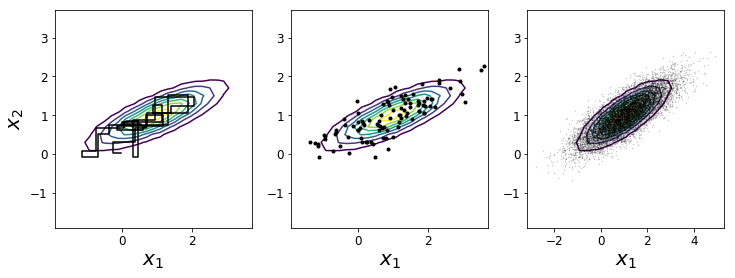

In [2]:
# Gibbs采样示例

mu = np.array([1.,1.])
s1 = 1. #sig_1**2
s2 = 0.2 #sig_2**2
rho = 0.8 
sig = np.array([[s1, rho*np.sqrt(s1*s2)],[rho*np.sqrt(s1*s2),s2]])   #协方差矩阵

# generate random numbers from 2D normal distribution
xx = np.random.multivariate_normal(mu,sig,100000)   #多元正态随机数生成
xgrid = np.arange(-2.,4.,0.2)
ygrid = np.arange(-2.,4.,0.2)
xcenter = (xgrid[0:-1]+xgrid[1:])/2.
ycenter = (ygrid[0:-1]+ygrid[1:])/2.

# make 2d histogram
hxx,xedge,yedge = np.histogram2d(xx[:,0],xx[:,1],bins=[xgrid,ygrid])

# Gibbs采样
xx_g = np.zeros((100000,2))
xx_g1 = np.zeros((200000,2))

xx_g[0,0]=np.random.uniform(-3,3)
xx_g[0,1] = np.random.normal(mu[1]+rho*np.sqrt(s2/s1)*(xx_g[0,0]-mu[0]),
                             np.sqrt(s2*(1-rho**2)))   #根据P48公式，条件概率分布
xx_g1[0,:] = xx_g[0]

for i in range(1,100000):   #跳过第一个，也就是上面的xx_g[0,1]
    xx_g[i,0] = np.random.normal(mu[0]+rho*np.sqrt(s1/s2)*(xx_g[i-1,1]-mu[1]),
                                 np.sqrt(s1*(1.-rho**2)))   
                                 #给定x2，根据x1的条件概率分布抽随机数
    xx_g[i,1] = np.random.normal(mu[1]+rho*np.sqrt(s2/s1)*(xx_g[i,0]-mu[0]),
                                 np.sqrt(s2*(1.-rho**2)))   
                                 #给定x1，根据x2的条件概率分布抽随机数
    
    #below is for drawing the steps 每走一步存一步
    xx_g1[2*i-1,0] = xx_g[i,0]
    xx_g1[2*i-1,1] = xx_g[i-1,1]
    xx_g1[2*i,0] = xx_g[i,0]
    xx_g1[2*i,1] = xx_g[i,1]
    
# xgrid = np.arange(-2.,4.,0.2)
# ygrid = np.arange(-2.,4.,0.2)
# xcenter = (xgrid[0:-1]+xgrid[1:])/2.
# ycenter = (ygrid[0:-1]+ygrid[1:])/2.
# hxx_g,xedge,yedge = np.histogram2d(xx_g[:,0],
#                     xx_g[:,1],bins=[xgrid,ygrid])

fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(131)
#ax.plot(xx_g[0:10,0],xx_g[0:10,1],'k')
ax.plot(xx_g1[0:50,0],xx_g1[0:50,1],'k')
#ax.contour(xcenter,ycenter,hxx.T,colors='c')
ax.contour(xcenter,ycenter,hxx.T)   ###此处需要把hxx转置(.T)，python二维数组定义第一维是行（y轴），第二维是列（x轴）
ax.set_xlabel(r'$x_1$',fontsize=20)
ax.set_ylabel(r'$x_2$',fontsize=20)

ax = fig.add_subplot(132)
ax.plot(xx_g[0:100,0],xx_g[0:100,1],'k.')   #不画轨迹，只画抽样点
#ax.plot(xx_g1[0:200,0],xx_g1[0:200,1],'k')
ax.contour(xcenter,ycenter,hxx.T)
ax.set_xlabel(r'$x_1$',fontsize=20)
#ax.set_ylabel(r'$x_2$',fontsize=20)

ax = fig.add_subplot(133)
ax.plot(xx_g[0:10000,0],xx_g[0:10000,1],'k.',markersize=1,alpha=0.2)   #前10000个抽样点
#ax.plot(xx_g1[0:2000,0],xx_g1[0:2000,1],'k')
ax.contour(xcenter,ycenter,hxx.T)
ax.set_xlabel(r'$x_1$',fontsize=20)
#ax.set_ylabel(r'$x_2$',fontsize=20)

acceptance rate for chain 1 is 0.62
acceptance rate for chain 1 is 0.61
acceptance rate for chain 1 is 0.62
acceptance rate for chain 1 is 0.63


Text(0.5,0,'$x_1$')

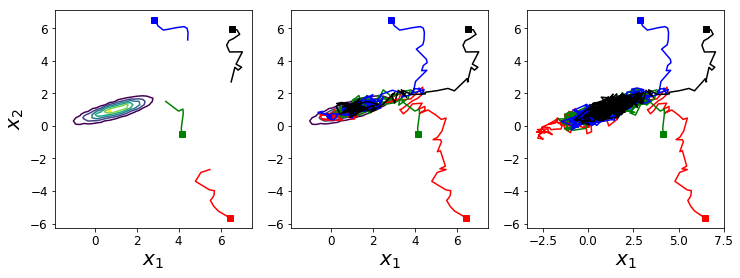

In [3]:
# Metropolis采样示例

mu = np.array([1.,1.])
s1 = 1.
s2 = 0.2
rho = 0.8
cov = np.array([[s1, rho*np.sqrt(s1*s2)],[rho*np.sqrt(s1*s2),s2]])

# generate random numbers from 2D normal distribution
xx = np.random.multivariate_normal(mu,cov,100000) 
xgrid = np.arange(-2.,4.,0.2)
ygrid = np.arange(-2.,4.,0.2)
xcenter = (xgrid[0:-1]+xgrid[1:])/2.
ycenter = (ygrid[0:-1]+ygrid[1:])/2.

# make 2d histogram
hxx,xedge,yedge = np.histogram2d(xx[:,0],xx[:,1],bins=[xgrid,ygrid])

# covariance for proposed distribution 建议分布
cov_prop = np.array([[0.1,0.0],[0.0,0.1]]) 

# 建议密度的sigma（对角项）决定了收敛情况：
# sigma较小时，每次迈的步子小，收敛慢，但收敛之后采样效果更好，接受率高
# sigma较大时，每次迈的步子大，收敛快，但容易迈出去，接受率低

# A chain
def chain(mu,cov,cov_prop,N):
    xx_g1 = np.zeros((N,2))
    pp1 = np.zeros((N,1)) 
    xx_g1[0,:] = np.random.uniform(-10.,10.,size=2)   #-10到10的均匀分布中随机一点做初值
    pp1[0] = stats.multivariate_normal.pdf(xx_g1[0,:],mu,cov)
    n_acc = 0
    n_all = 0
    for i in range(1,N):
        # draw the poprsal quantity from the proposal distribution
        xx = np.random.multivariate_normal(xx_g1[i-1,:],cov_prop,1)
        p1 = stats.multivariate_normal.pdf(xx, mu,cov)
        r0 = p1/pp1[i-1]
        if np.random.rand()<r0:
            xx_g1[i,:] = xx
            pp1[i] = p1
            n_acc += 1
        else:
            xx_g1[i,:] = xx_g1[i-1,:]
            pp1[i] = pp1[i-1]
        n_all += 1
    print('acceptance rate for chain 1 is %(n).2f' % {'n': n_acc/float(n_all)})
    return xx_g1


N = 10000

# 4 walkers
xx_g1 = chain(mu,cov,cov_prop,N)
xx_g2 = chain(mu,cov,cov_prop,N)
xx_g3 = chain(mu,cov,cov_prop,N)
xx_g4 = chain(mu,cov,cov_prop,N)

xgrid = np.arange(-2.,4.,0.2)
ygrid = np.arange(-2.,4.,0.2)
xcenter = (xgrid[0:-1]+xgrid[1:])/2.
ycenter = (ygrid[0:-1]+ygrid[1:])/2.
hxx_g1,xedge,yedge = np.histogram2d(\
    xx_g1[:,0],xx_g1[:,1],bins=[xgrid,ygrid])
hxx_g2,xedge,yedge = np.histogram2d(\
    xx_g2[:,0],xx_g2[:,1],bins=[xgrid,ygrid])
hxx_g3,xedge,yedge = np.histogram2d(\
    xx_g3[:,0],xx_g3[:,1],bins=[xgrid,ygrid])
hxx_g4,xedge,yedge = np.histogram2d(\
    xx_g4[:,0],xx_g4[:,1],bins=[xgrid,ygrid])
hxx = hxx_g1 + hxx_g2 + hxx_g3 + hxx_g4

fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(131)
n = 20
ax.plot(xx_g1[0:n,0],xx_g1[0:n,1],'r')
ax.plot(xx_g2[0:n,0],xx_g2[0:n,1],'g')
ax.plot(xx_g3[0:n,0],xx_g3[0:n,1],'b')
ax.plot(xx_g4[0:n,0],xx_g4[0:n,1],'k')
ax.plot(xx_g1[0,0],xx_g1[0,1],'rs')
ax.plot(xx_g2[0,0],xx_g2[0,1],'gs')
ax.plot(xx_g3[0,0],xx_g3[0,1],'bs')
ax.plot(xx_g4[0,0],xx_g4[0,1],'ks')
ax.contour(xcenter,ycenter,hxx.T)
ax.set_xlabel(r'$x_1$',fontsize=20)
ax.set_ylabel(r'$x_2$',fontsize=20)

ax = fig.add_subplot(132)
n = 200
ax.plot(xx_g1[0:n,0],xx_g1[0:n,1],'r')
ax.plot(xx_g2[0:n,0],xx_g2[0:n,1],'g')
ax.plot(xx_g3[0:n,0],xx_g3[0:n,1],'b')
ax.plot(xx_g4[0:n,0],xx_g4[0:n,1],'k')
ax.plot(xx_g1[0,0],xx_g1[0,1],'rs')
ax.plot(xx_g2[0,0],xx_g2[0,1],'gs')
ax.plot(xx_g3[0,0],xx_g3[0,1],'bs')
ax.plot(xx_g4[0,0],xx_g4[0,1],'ks')
ax.contour(xcenter,ycenter,hxx.T)
ax.set_xlabel(r'$x_1$',fontsize=20)
#ax.set_ylabel(r'$x_2$',fontsize=20)

ax = fig.add_subplot(133)
n = 1000
ax.plot(xx_g1[0:n,0],xx_g1[0:n,1],'r')
ax.plot(xx_g2[0:n,0],xx_g2[0:n,1],'g')
ax.plot(xx_g3[0:n,0],xx_g3[0:n,1],'b')
ax.plot(xx_g4[0:n,0],xx_g4[0:n,1],'k')
ax.plot(xx_g1[0,0],xx_g1[0,1],'rs')
ax.plot(xx_g2[0,0],xx_g2[0,1],'gs')
ax.plot(xx_g3[0,0],xx_g3[0,1],'bs')
ax.plot(xx_g4[0,0],xx_g4[0,1],'ks')
ax.contour(xcenter,ycenter,hxx.T)
ax.set_xlabel(r'$x_1$',fontsize=20)
#ax.set_ylabel(r'$x_2$',fontsize=20)

Text(0,0.5,'$x_2$')

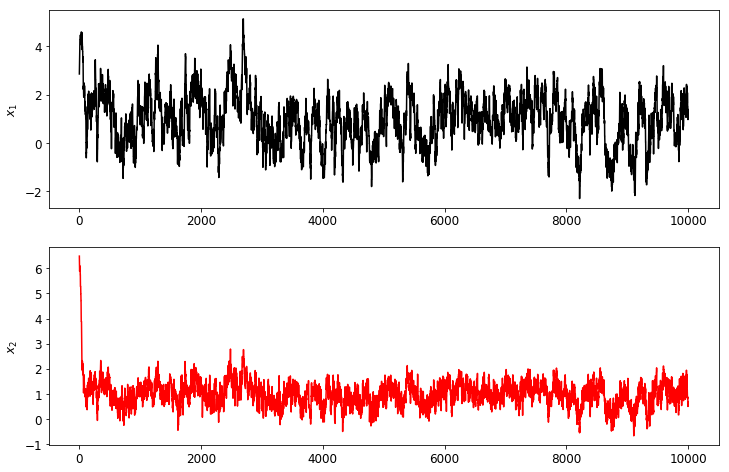

In [4]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(211)
n = 10000
ax.plot(xx_g3[0:n,0],'k')
ax.set_ylabel(r'$x_1$',fontsize=12)
ax = fig.add_subplot(212)
ax.plot(xx_g3[0:n,1],'r')
ax.set_ylabel(r'$x_2$',fontsize=12)

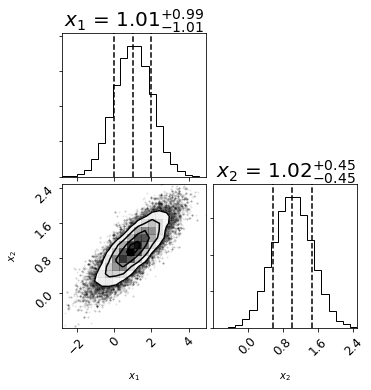

In [5]:
# redo this with emcee package

def lnprob(x, mu, cov):
    return np.log(stats.multivariate_normal.pdf(x,mu,cov))

ndim = 2

mu = np.array([1.,1.])
s1 = 1.
s2 = 0.2
rho = 0.8
cov = np.array([[s1, rho*np.sqrt(s1*s2)],\
        [rho*np.sqrt(s1*s2),s2]])

# generate random numbers from 2D normal distribution
xx = np.random.multivariate_normal(mu,cov,100000) 
xgrid = np.arange(-2.,4.,0.2)
ygrid = np.arange(-2.,4.,0.2)
xcenter = (xgrid[0:-1]+xgrid[1:])/2.
ycenter = (ygrid[0:-1]+ygrid[1:])/2.

# make 2d histogram
hxx,xedge,yedge = np.histogram2d(\
                xx[:,0],xx[:,1],bins=[xgrid,ygrid])

# start to configure emcee
nwalkers = 50

p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))   #设定50个walker的随机初始点
sampler = emcee.EnsembleSampler(nwalkers, \
        ndim, lnprob, args=[mu, cov])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()   #重置，前100次扔掉（burn-in）

sampler.run_mcmc(pos, 1000)   #从100步以后的位置继续行走1000次

samples = sampler.chain[:, :, :].reshape((-1, ndim))   #重整矩阵

fig = corner.corner(samples,labels=[r"$x_1$", r"$x_2$"],\
                       quantiles=[0.16, 0.5, 0.84],\   #百分位数线
                       show_titles=True,\   #显示标题
                       title_kwargs={"fontsize": 20})   #标题大小

F:\Anaconda\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mean acceptance fraction: 0.191
escape time: 2.6878156661987305  sec


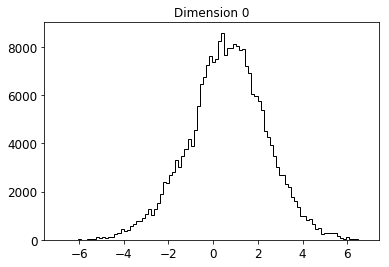

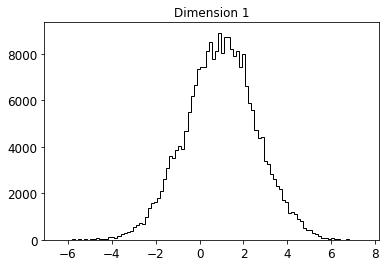

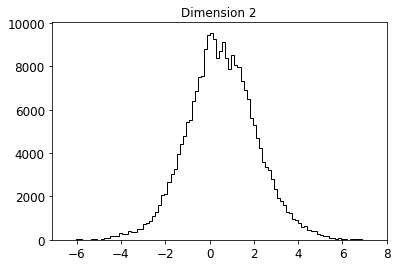

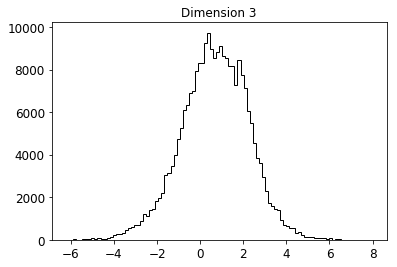

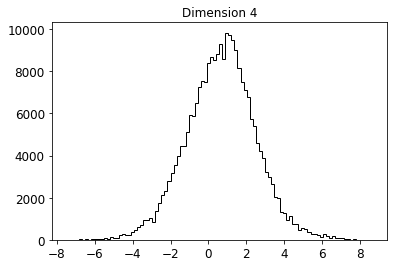

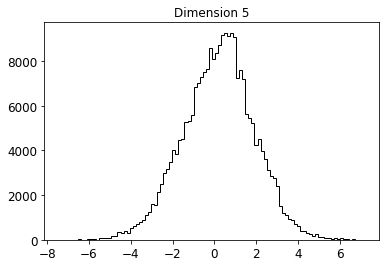

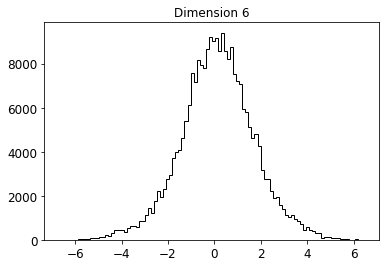

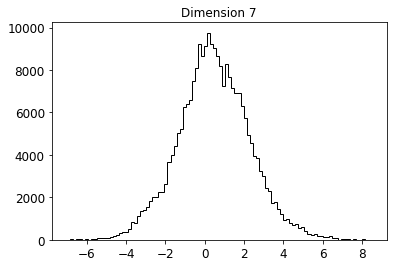

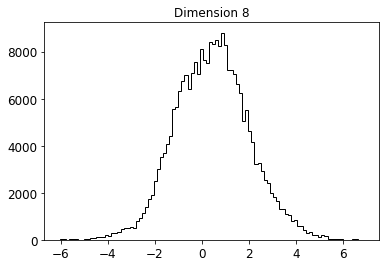

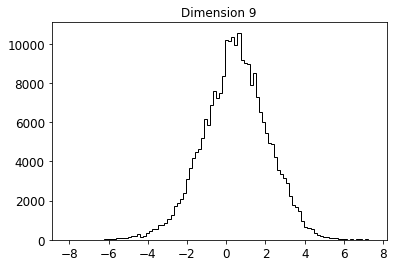

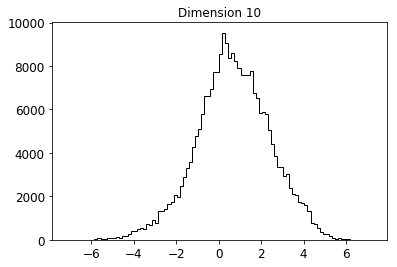

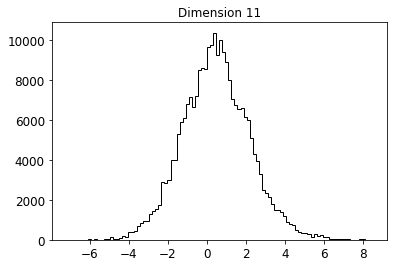

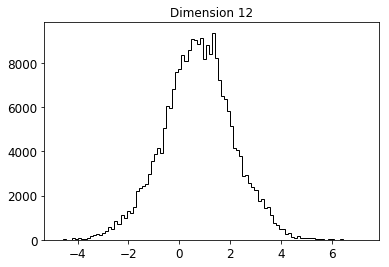

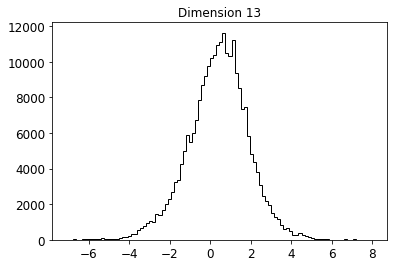

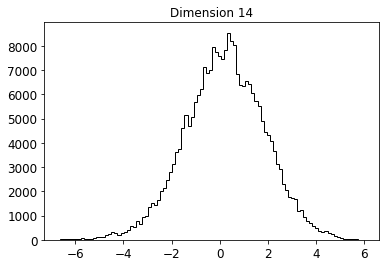

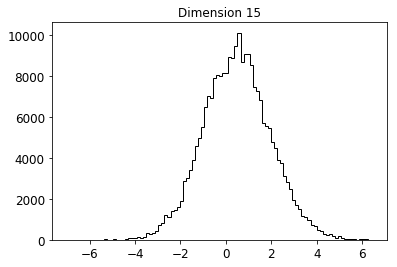

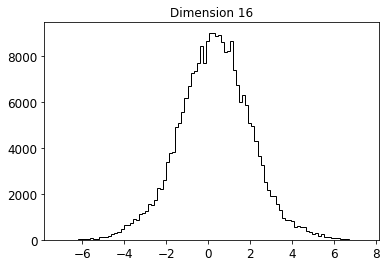

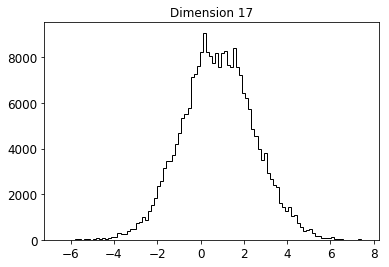

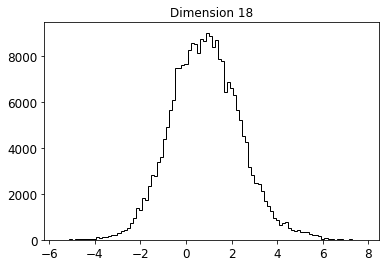

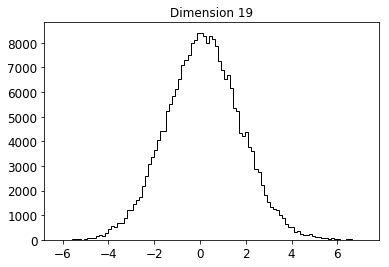

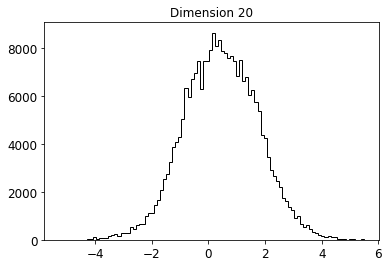

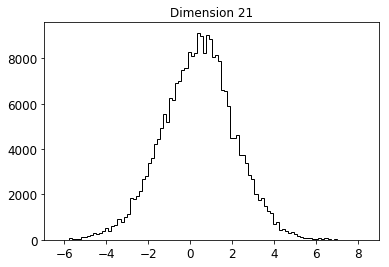

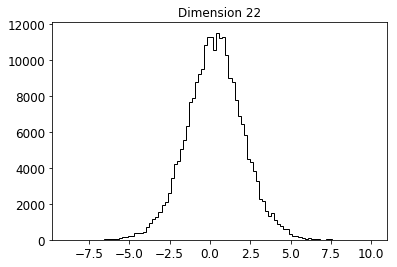

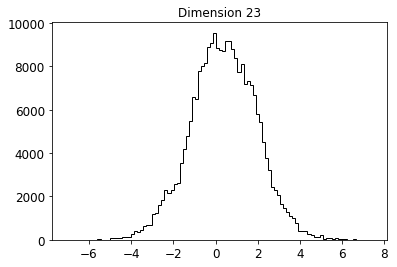

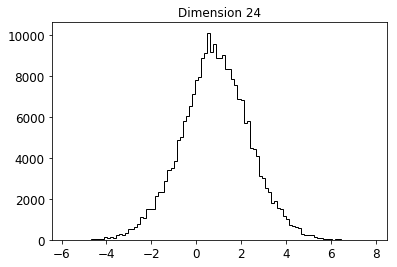

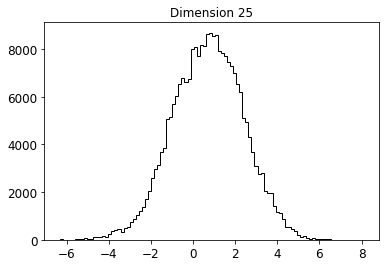

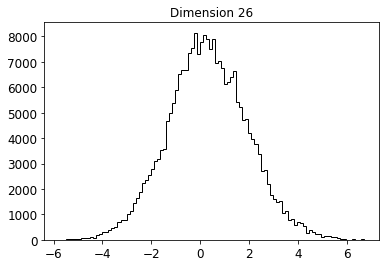

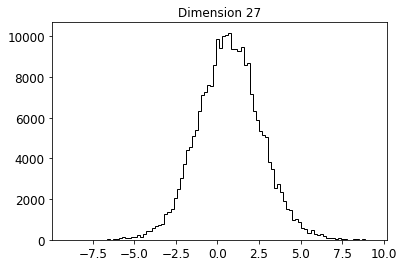

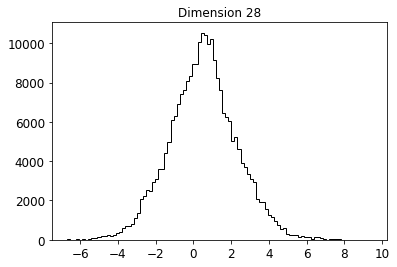

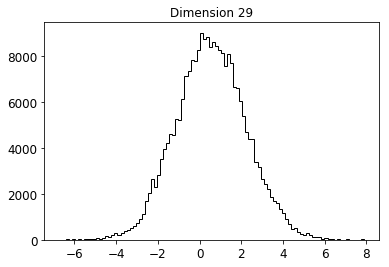

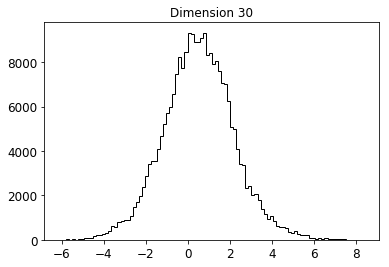

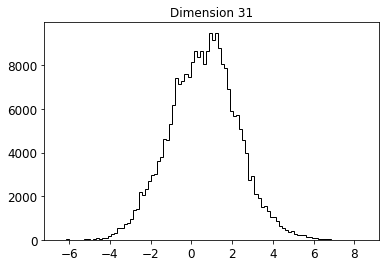

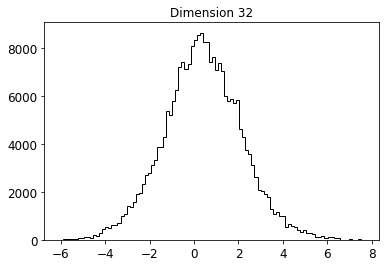

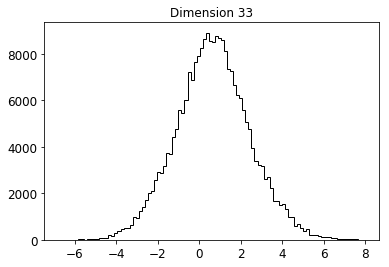

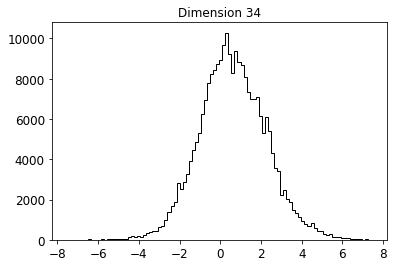

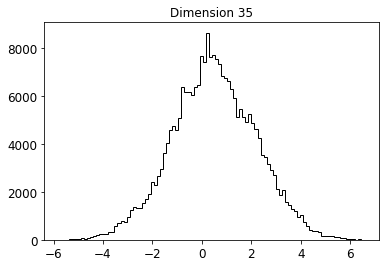

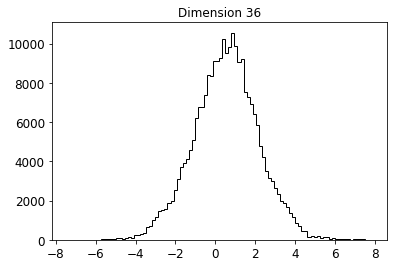

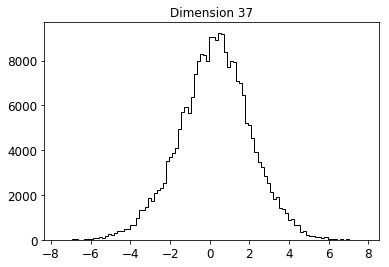

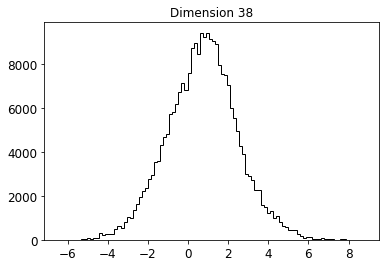

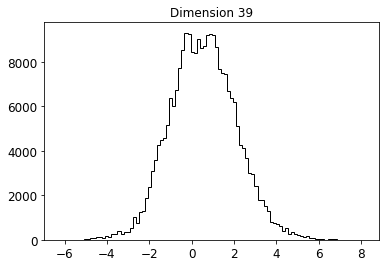

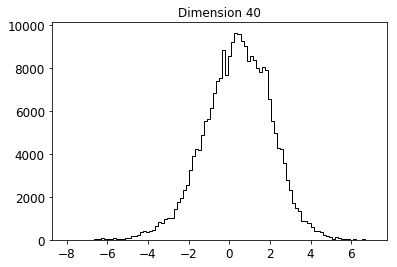

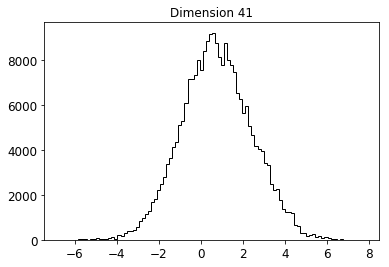

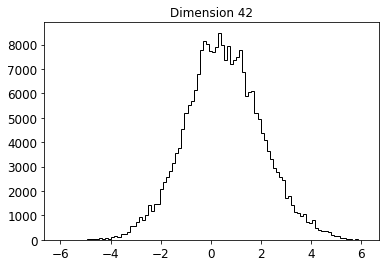

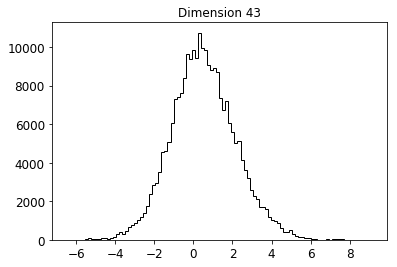

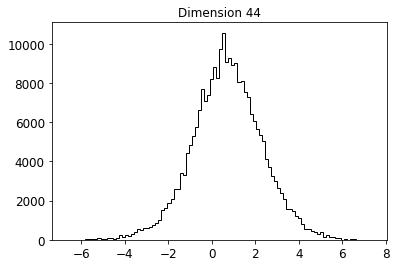

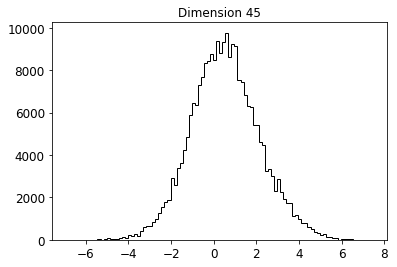

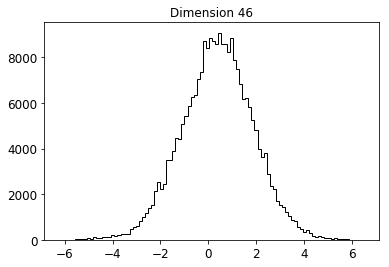

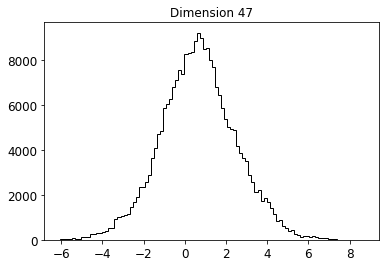

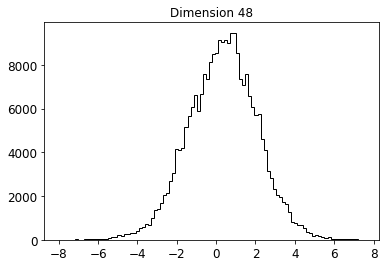

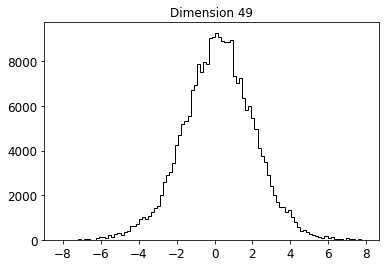

In [7]:
# 50维抽样

import time

def lnprob(x, mu, icov):
    diff = x-mu
    return -np.dot(diff,np.dot(icov,diff))/2.0

ndim = 50

means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

icov = np.linalg.inv(cov)

start = time.time()
nwalkers = 250
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
print("escape time:",time.time()-start,' sec')